In [1]:
import math
import numpy as np
import pandas as pd
from datetime import date, datetime

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

SEED = 42

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 3.1 Data

### Data Loading

##### Daily Stock File

In [2]:
# Convert Data Type
stock_df = pd.read_csv('./data/Daily_Stock.csv')
stock_df['PERMNO'] = pd.to_numeric(stock_df['PERMNO'], errors='coerce')
stock_df['RET'] = pd.to_numeric(stock_df['RET'], errors='coerce')
stock_df['MKT'] = pd.to_numeric(stock_df['vwretd'], errors='coerce')
stock_df['PRC'] = np.abs(pd.to_numeric(stock_df['PRC'], errors='coerce'))
stock_df['SHROUT'] = pd.to_numeric(stock_df['SHROUT'], errors='coerce')
stock_df['date'] = pd.to_datetime(stock_df['date'], errors='coerce')

# Assign Derived Columns
stock_df['CAP'] = stock_df['SHROUT'] * stock_df['PRC']
stock_df['DATE'] = stock_df['date']
stock_df['YEAR'] = stock_df['date'].dt.year
stock_df['MONTH'] = stock_df['date'].dt.month

# Drop Unnecessary Columns
stock_df = stock_df.drop(columns=['vwretd', 'SHROUT', 'PRC', 'date'])
stock_df = stock_df.dropna().drop_duplicates()
print(stock_df.shape)
print(stock_df.head())

TimeoutError: [Errno 60] Operation timed out

##### 207 Characteristics

In [ ]:
# characteristics_df = pd.read_csv('./data/Characteristics.csv')
# characteristics_df['yyyymm'] = pd.to_datetime(characteristics_df['yyyymm'], format='%Y%m')
# characteristics_df['YEAR'] = characteristics_df['yyyymm'].dt.year
# characteristics_df['MONTH'] = characteristics_df['yyyymm'].dt.month
# characteristics_df = characteristics_df.drop(columns=['yyyymm']).rename(columns={'permno': 'PERMNO'})
# characteristics_df = characteristics_df.dropna(subset=['PERMNO', 'YEAR', 'MONTH'])
# # characteristics_df = characteristics_df.dropna(axis=1, thresh=(0.8 * len(characteristics_df))) # Drop columns with more than 20% missing values
# # characteristics_df = characteristics_df.fillna(0)
# print(characteristics_df.shape)
# print(characteristics_df.head())

(5273600, 212)
   PERMNO  AM  AOP  AbnormalAccruals  Accruals  AccrualsBM  Activism1  \
0   10000 NaN  NaN               NaN       NaN         NaN        NaN   
1   10000 NaN  NaN               NaN       NaN         NaN        NaN   
2   10000 NaN  NaN               NaN       NaN         NaN        NaN   
3   10000 NaN  NaN               NaN       NaN         NaN        NaN   
4   10000 NaN  NaN               NaN       NaN         NaN        NaN   

   Activism2  AdExp  AgeIPO  AnalystRevision  AnalystValue  \
0        NaN    NaN     NaN              NaN           NaN   
1        NaN    NaN     NaN              NaN           NaN   
2        NaN    NaN     NaN              NaN           NaN   
3        NaN    NaN     NaN              NaN           NaN   
4        NaN    NaN     NaN              NaN           NaN   

   AnnouncementReturn  AssetGrowth  BM  BMdec  BPEBM  Beta  BetaFP  \
0                 NaN          NaN NaN    NaN    NaN   NaN     NaN   
1                 NaN          Na

##### 73 Financial Ratios

In [ ]:
finance_ratio_df = pd.read_csv('./data/Financial_Ratios.csv')
finance_ratio_df = finance_ratio_df.drop(columns=['adate', 'qdate'])
finance_ratio_df['public_date'] = pd.to_datetime(finance_ratio_df['public_date'], errors='coerce')
finance_ratio_df['YEAR'] = finance_ratio_df['public_date'].dt.year
finance_ratio_df['MONTH'] = finance_ratio_df['public_date'].dt.month
finance_ratio_df = finance_ratio_df.dropna(subset=['public_date'])

exclude_columns = ['YEAR', 'MONTH', 'gvkey', 'cusip', 'TICKER']
finance_ratio_df.loc[:, ~finance_ratio_df.columns.isin(exclude_columns)] = (
    finance_ratio_df.loc[:, ~finance_ratio_df.columns.isin(exclude_columns)]
    .apply(pd.to_numeric, errors='coerce')
)
print(finance_ratio_df.shape)
print(finance_ratio_df.head())

### Data Processing

In [ ]:
def stock_data_processing(stock_df):
    # Excludes stocks below the 20th percentile of NYSE market capitalization
    stock_df = stock_df[stock_df['CAP'] > stock_df['CAP'].quantile(0.2)].copy()

    # Winsorize the return data at the 1st and 99th percentiles
    stock_df['RET'] = stock_df['RET'].clip(
        lower=stock_df['RET'].quantile(0.01),
        upper=stock_df['RET'].quantile(0.99)
    )

    # Demeaining the return data with rolling 1-year window
    stock_df['rolling_mean_RET'] = (
        stock_df.groupby('PERMNO')['RET']
        .transform(lambda x: x.rolling(window=252, min_periods=1).mean())
    )
    stock_df['demeaned_RET'] = stock_df['RET'] - stock_df['rolling_mean_RET']
    return stock_df

stock_df = stock_data_processing(stock_df)

In [ ]:
# Randomly sample 1000 firms each year
def sample_firms_by_year(df, num_firms=1000):
    sampled_data = []
    unique_years = df['YEAR'].unique()

    for year in unique_years:
        yearly_data = df[df['YEAR'] == year]
        sampled_permnos = yearly_data['PERMNO'].drop_duplicates().sample(n=min(num_firms, len(yearly_data['PERMNO'].unique())), random_state=SEED)
        sampled_data.append(yearly_data[yearly_data['PERMNO'].isin(sampled_permnos)])

    return pd.concat(sampled_data)

large_sampled_stock_df = sample_firms_by_year(stock_df, num_firms=1000)
small_sampled_stock_df = sample_firms_by_year(stock_df, num_firms=100)

## 3.2 Latent Factors

##### Figure 1

In [ ]:
def compute_principal_components(stock_df, window_month=None):
    # Step 1: Pivot the data into matrix form
    pivot_data = stock_df[['DATE', 'PERMNO', 'demeaned_RET']].copy()
    if window_month is not None:
        start_date = pivot_data['DATE'].max() - pd.DateOffset(months=window_month)
        pivot_data = pivot_data[pivot_data['DATE'] >= start_date]
    pivot_data = pivot_data.pivot(index='DATE', columns='PERMNO', values='demeaned_RET').fillna(0)

    # Step 2: Perform Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(pivot_data.values, full_matrices=False)  # SVD decomposition
    V = Vt.T  # Transpose Vt to get eigenvectors (betas)

    # Step 3: Compute omega_1 for scaling
    omega_1 = 1 / np.sum(V[:, 0])  # Scaling factor based on the first eigenvector

    # Step 4: Scale all eigenvectors (betas) using omega_1^{-1}
    betas = V / omega_1  # Scale all eigenvectors by omega_1^{-1}

    # Step 5: Compute latent factors using R^T * V_k * omega_1
    latent_factors = np.dot(pivot_data.values, betas)  # R^T * betas
    latent_factors_df = pd.DataFrame(
        latent_factors,
        index=pivot_data.index,  # Stocks (PERMNO) as index
        columns=[f"Latent Factor {i+1}" for i in range(latent_factors.shape[1])]
    )

    # Step 6: Compute explained variance
    T = pivot_data.shape[0]  # Number of time periods (rows)
    explained_variance = (S**2) / T  # Explained variance as fraction of total variance
    explained_variance = explained_variance / np.sum(explained_variance)

    return latent_factors_df, betas, explained_variance


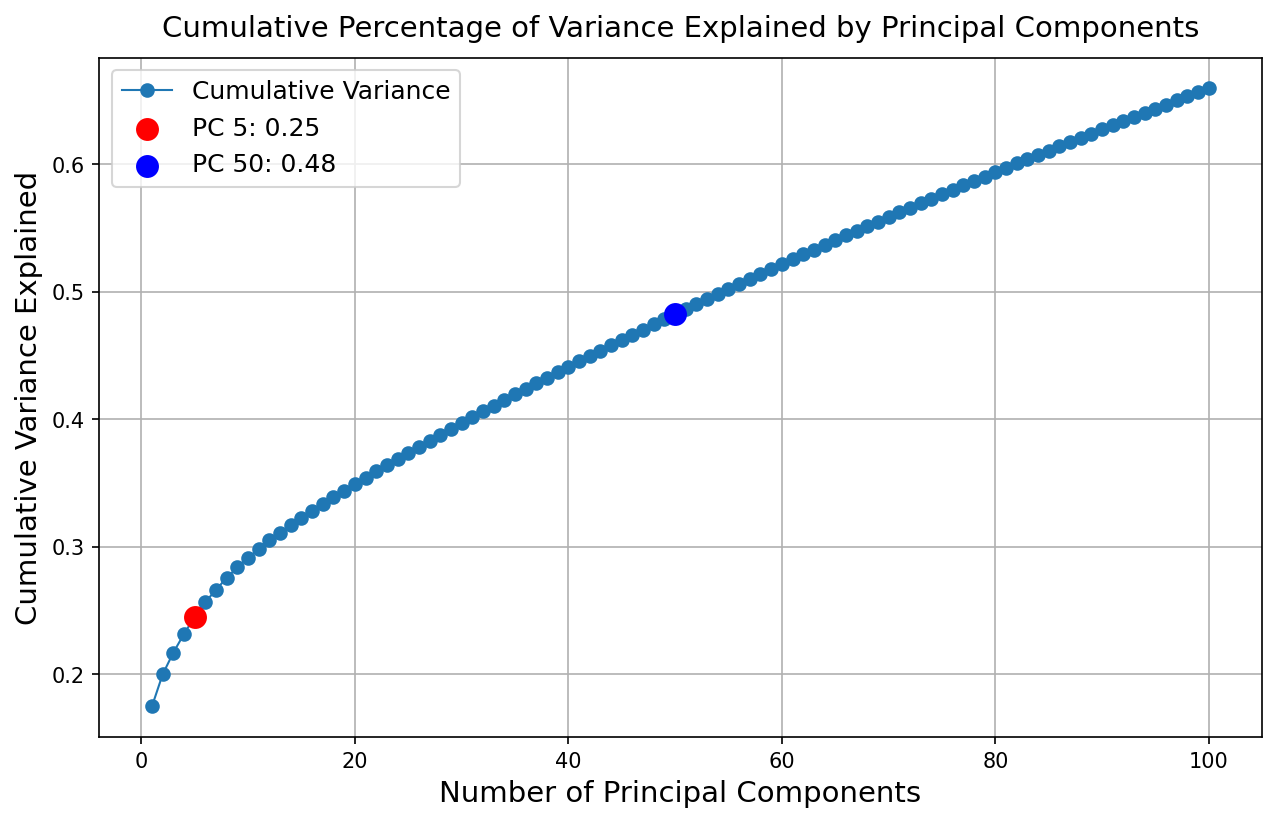

In [ ]:
def replicate_figure_1(stock_df):
    _, _, explained_variance = compute_principal_components(stock_df, window_month=12)
    cumulative_variance = np.cumsum(explained_variance)
    cumulative_variance = cumulative_variance[:100] # Limit to 100 principal components
    y_value_pc5 = cumulative_variance[4]  # 5th principal component (index 4)
    y_value_pc50 = cumulative_variance[49]  # 50th principal component (index 49)

    plt.figure(figsize=(10, 6), dpi=150)
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', linewidth=1, label='Cumulative Variance')
    plt.scatter(5, y_value_pc5, color='red', s=100, label=f'PC 5: {y_value_pc5:.2f}', zorder=2)
    plt.scatter(50, y_value_pc50, color='blue', s=100, label=f'PC 50: {y_value_pc50:.2f}', zorder=2)
    plt.title('Cumulative Percentage of Variance Explained by Principal Components', fontsize=14, pad=10)
    plt.xlabel('Number of Principal Components', fontsize=14)
    plt.ylabel('Cumulative Variance Explained', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.savefig('./pics/figure_1.png')
    plt.show()

replicate_figure_1(stock_df)


##### Figure 3

Processing chunk 1/10
Processing month: 1974-01
Processing month: 1974-02
Processing month: 1974-03
Processing month: 1974-04
Processing month: 1974-05
Processing month: 1974-06
Processing month: 1974-07
Processing month: 1974-08
Processing month: 1974-09
Processing month: 1974-10
Processing month: 1974-11
Processing month: 1974-12
Processing month: 1975-01
Processing month: 1975-02
Processing month: 1975-03
Processing month: 1975-04
Processing month: 1975-05
Processing month: 1975-06
Processing month: 1975-07
Processing month: 1975-08
Processing month: 1975-09
Processing month: 1975-10
Processing month: 1975-11
Processing month: 1975-12
Processing month: 1976-01
Processing month: 1976-02
Processing month: 1976-03
Processing month: 1976-04
Processing month: 1976-05
Processing month: 1976-06
Processing month: 1976-07
Processing month: 1976-08
Processing month: 1976-09
Processing month: 1976-10
Processing month: 1976-11
Processing month: 1976-12
Processing month: 1977-01
Processing month

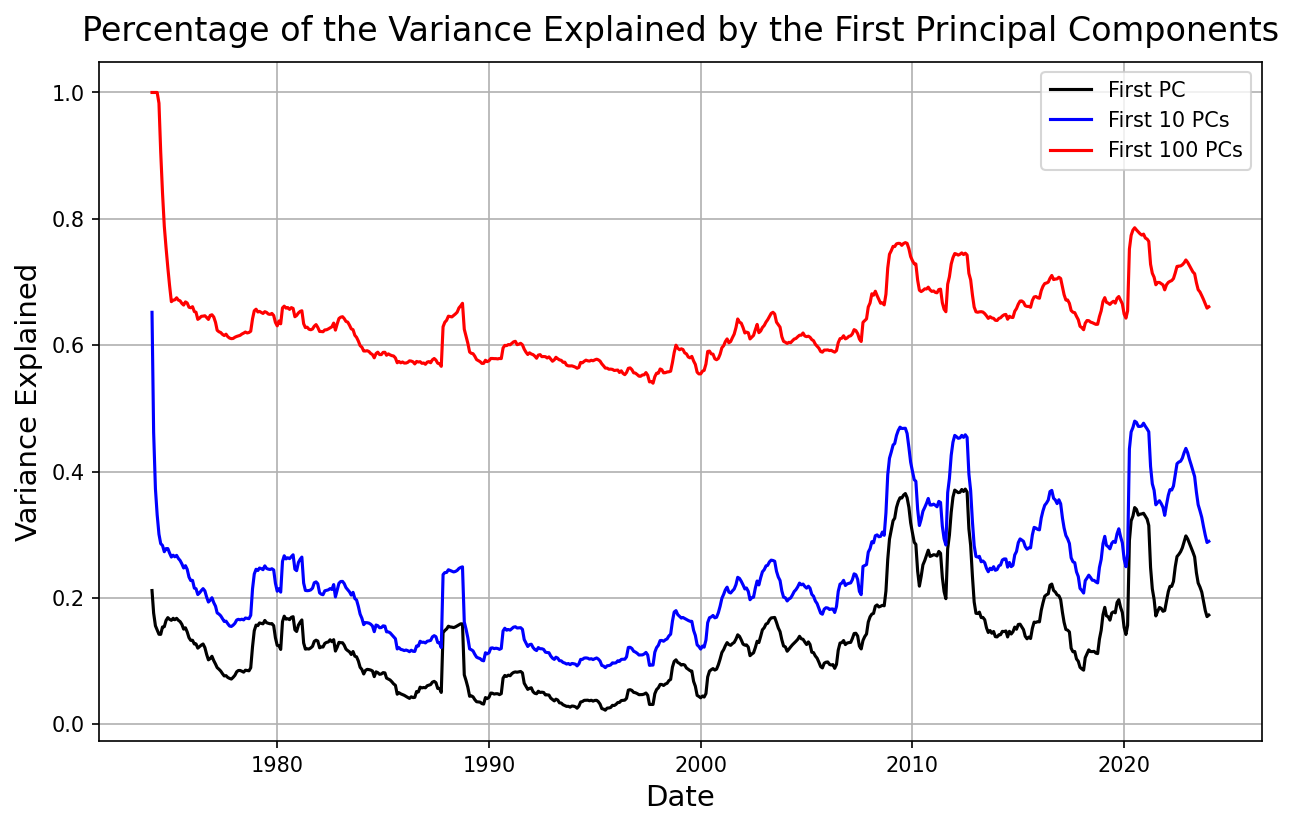

In [ ]:
def replicate_figure_3(stock_df, chunk_size=60):
    # Ensure DATE column is properly formatted
    stock_df['DATE'] = pd.to_datetime(stock_df['DATE']).dt.normalize()
    stock_df = stock_df.sort_values(by='DATE').reset_index(drop=True)

    # Prepare unique months and variance explained DataFrame
    unique_months = stock_df['DATE'].dt.to_period('M').unique()
    variance_explained = {
        'DATE': [],
        'First PC': [],
        'First 10 PCs': [],
        'First 100 PCs': []
    }

    # Divide unique_months into chunks of size chunk_size
    chunks = [unique_months[i:i + chunk_size] for i in range(0, len(unique_months), chunk_size)]

    for chunk_index, chunk in enumerate(chunks):
        print(f"Processing chunk {chunk_index + 1}/{len(chunks)}")

        for month in chunk:
            print(f"Processing month: {month}")

            # Filter stock data for the 12 months ending in the current month
            end_date = month.to_timestamp(how='end').normalize()
            start_date = (end_date - pd.DateOffset(months=12)).normalize()
            window_df = stock_df[(stock_df['DATE'] > start_date) & (stock_df['DATE'] <= end_date)]

            # Skip if insufficient data
            if len(window_df) == 0:
                continue

            # Compute principal components
            _, _, explained_variance = compute_principal_components(window_df, window_month=None)

            # Collect results
            variance_explained['DATE'].append(end_date)
            variance_explained['First PC'].append(np.sum(explained_variance[:1]))  # First PC
            variance_explained['First 10 PCs'].append(np.sum(explained_variance[:10]))  # First 10 PCs
            variance_explained['First 100 PCs'].append(np.sum(explained_variance[:100]))  # First 100 PCs

        # Save intermediate results after each chunk
        intermediate_df = pd.DataFrame(variance_explained)
        intermediate_df.to_csv(f'./pics/figure_3_data/intermediate_results_chunk_{chunk_index + 1}.csv', index=False)

    # Combine all results
    variance_explained_df = pd.DataFrame(variance_explained)

    # Plot the time-varying explained variance
    plt.figure(figsize=(10, 6), dpi=150)
    plt.plot(variance_explained_df['DATE'], variance_explained_df['First PC'], label='First PC', color='black')
    plt.plot(variance_explained_df['DATE'], variance_explained_df['First 10 PCs'], label='First 10 PCs', color='blue')
    plt.plot(variance_explained_df['DATE'], variance_explained_df['First 100 PCs'], label='First 100 PCs', color='red')
    plt.title('Percentage of the Variance Explained by the First Principal Components', fontsize=16, pad=10)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Variance Explained', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.savefig('./pics/figure_3.png')
    plt.show()


replicate_figure_3(stock_df, chunk_size=60)


##### Table 1

In [ ]:
table_1 = mpimg.imread('./target/table_1.png')
plt.figure(figsize=(10, 10), dpi=150)
plt.imshow(table_1)
plt.axis('off')
plt.show()